#### Data & Modules Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install mne
! pip install neurodsp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00


In [4]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neurodsp as ndsp
from neurodsp import spectral

from sklearn.cross_decomposition import CCA

mne.set_log_level('ERROR')

In [5]:
pre_dir = "/content/drive/My Drive/TBI_data/pre_retreat/"
post_dir = "/content/drive/My Drive/TBI_data/post_retreat/"

In [6]:
pre_raw = [mne.io.read_raw_edf(pre_dir+file, preload=True) for file in os.listdir(pre_dir)]
post_raw = [mne.io.read_raw_edf(post_dir+file, preload=True) for file in os.listdir(post_dir)]

In [7]:
len(pre_raw), len(post_raw)

(21, 21)

#### Extract Last 7 Seconds Of EEG Data

<ipython-input-9-ce5c25c32742>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')
<ipython-input-9-ce5c25c32742>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(post_durations, kde=True, label='post_retreat recordings')


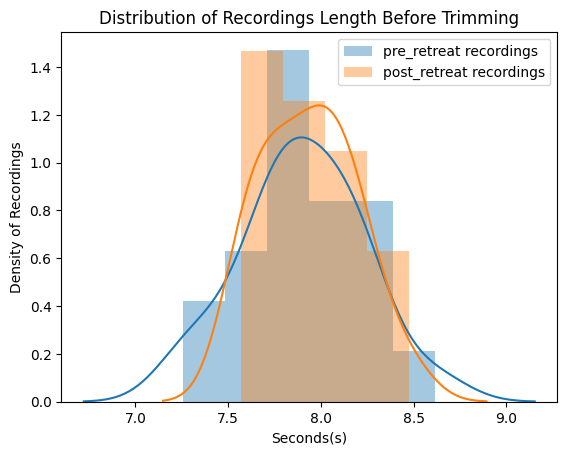

In [9]:
pre_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in pre_raw]
post_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in post_raw]

# Histogram and KDE for pre_retreat
sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')

# Histogram and KDE for post_retreat
sns.distplot(post_durations, kde=True, label='post_retreat recordings')

# Add labels and title
plt.xlabel('Seconds(s)')
plt.ylabel('Density of Recordings')
plt.title('Distribution of Recordings Length Before Trimming')
plt.legend()

# Show the plot
plt.show()

In [10]:
t_d = 15
pre_raw = [raw.crop(tmin=0,tmax=(raw.n_times/raw.info["sfreq"])-int(t_d/2)) for raw in pre_raw]
post_raw = [raw.crop(tmin=0,tmax=(raw.n_times/raw.info["sfreq"])-t_d) for raw in post_raw]

In [11]:
pre_raw = [raw.crop(tmin=raw.times[-1] - 7*60) if raw.n_times/(raw.info["sfreq"]*60)>7 else raw for raw in pre_raw]
post_raw = [raw.crop(tmin=raw.times[-1] - 7*60) if raw.n_times/(raw.info["sfreq"]*60)>7 else raw for raw in post_raw]

<ipython-input-12-d18290e1a210>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-12-d18290e1a210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function fo

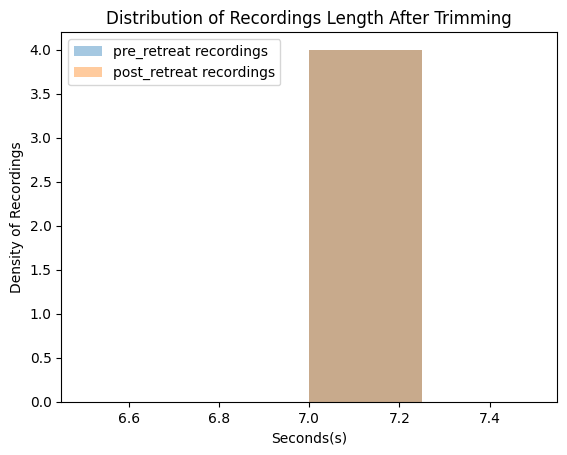

In [12]:
pre_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in pre_raw]
post_durations = [raw.n_times/(raw.info["sfreq"]*60) for raw in post_raw]

# Histogram and KDE for pre_retreat
sns.distplot(pre_durations, kde=True, label='pre_retreat recordings')

# Histogram and KDE for post_retreat
sns.distplot(post_durations, kde=True, label='post_retreat recordings')

# Add labels and title
plt.xlabel('Seconds(s)')
plt.ylabel('Density of Recordings')
plt.title('Distribution of Recordings Length After Trimming')
plt.legend()

# Show the plot
plt.show()

#### Add Electrode Montage to Recordings

In [13]:
drop_channels = ["Trigger","EEG CM-Pz","EEG X3-Pz","EEG X2-Pz","EEG X1-Pz"]

pre_raw = [raw.drop_channels(drop_channels) for raw in pre_raw]
post_raw = [raw.drop_channels(drop_channels) for raw in post_raw]

In [14]:
# Given channel names
channel_names = [
    'EEG P3-Pz', 'EEG C3-Pz', 'EEG F3-Pz', 'EEG Fz-Pz', 'EEG F4-Pz',
    'EEG C4-Pz', 'EEG P4-Pz', 'EEG Cz-Pz', 'EEG A1-Pz',
    'EEG Fp1-Pz', 'EEG Fp2-Pz', 'EEG T3-Pz', 'EEG T5-Pz', 'EEG O1-Pz',
    'EEG O2-Pz', 'EEG F7-Pz', 'EEG F8-Pz', 'EEG A2-Pz', 'EEG T6-Pz', 'EEG T4-Pz'
]

# Extract electrode names
electrode_name = lambda name: name.split()[1].split('-')[0]

# Standard 10-20 system coordinates (example for known electrodes)
ten_twenty_coords = mne.channels.make_standard_montage('standard_1020').get_positions()['ch_pos']

# Coordinates dictionary
coords = {}

# Define coordinates for known electrodes
for electrode in channel_names:
    electrode_ = electrode_name(electrode)
    if electrode_ in ten_twenty_coords:
        coords[electrode] = ten_twenty_coords[electrode_]

# Define coordinates for custom electrodes (X1, X2, X3, CM)
# Here we assign arbitrary coordinates or estimate positions
coords['X1'] = np.array([0, 0, 0])
coords['X2'] = np.array([0, 0, 0])
coords['X3'] = np.array([0, 0, 0])
coords['CM'] = np.array([0, 0, 0])  # Example coordinate

# Create montage
montage = mne.channels.make_dig_montage(ch_pos=coords)

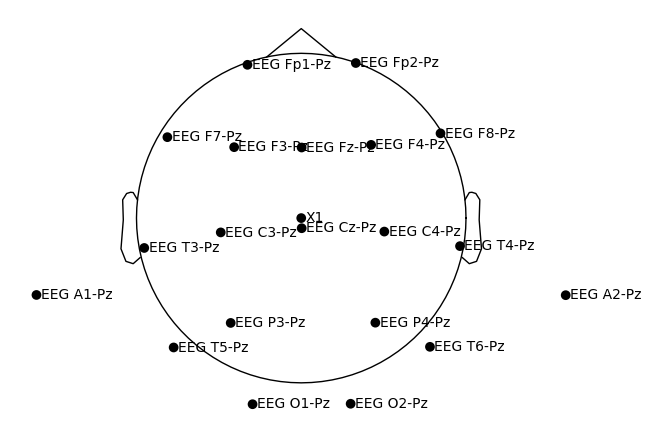

In [15]:
montage.plot()
plt.close("all")

In [16]:
pre_raw = [raw.set_montage(montage) for raw in pre_raw]
post_raw = [raw.set_montage(montage) for raw in post_raw]

#### Preprocessing of EEG Data

In [17]:
len(pre_raw), len(post_raw)

(21, 21)

In [18]:
post_lowcuts = [raw.info["lowpass"] for raw in post_raw]
pre_lowcuts = [raw.info["lowpass"] for raw in pre_raw]

post_highcuts = [raw.info["highpass"] for raw in post_raw]
pre_highcuts = [raw.info["highpass"] for raw in pre_raw]

post_linefreq = [raw.info["line_freq"] if raw.info["line_freq"]!=None else 0 for raw in post_raw]
pre_linefreq = [raw.info["line_freq"] if raw.info["line_freq"]!=None else 0 for raw in pre_raw]

post_sfreq = [raw.info["sfreq"] for raw in post_raw]
pre_sfreq = [raw.info["sfreq"] for raw in pre_raw]

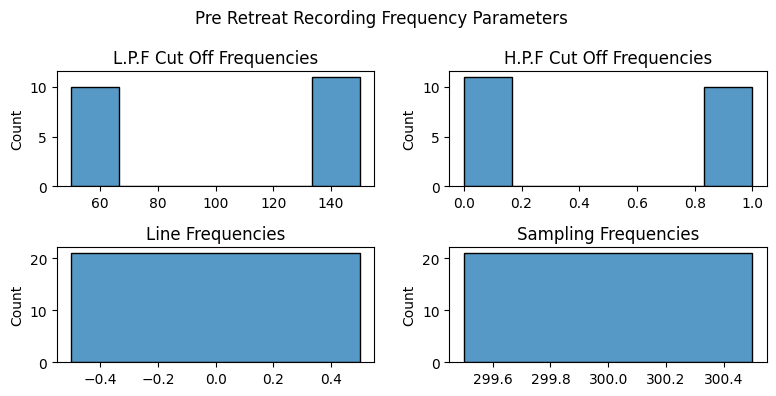

In [19]:
fig_, ax_ = plt.subplots(2, 2, figsize=(8,4))

sns.histplot(pre_lowcuts, ax=ax_[0,0])
ax_[0,0].set_title("L.P.F Cut Off Frequencies")

sns.histplot(pre_highcuts, ax=ax_[0,1])
ax_[0,1].set_title("H.P.F Cut Off Frequencies")

sns.histplot(pre_linefreq, ax=ax_[1,0])
ax_[1,0].set_title("Line Frequencies")

sns.histplot(pre_sfreq, ax=ax_[1,1])
ax_[1,1].set_title("Sampling Frequencies")

fig_.suptitle("Pre Retreat Recording Frequency Parameters")
fig_.tight_layout()

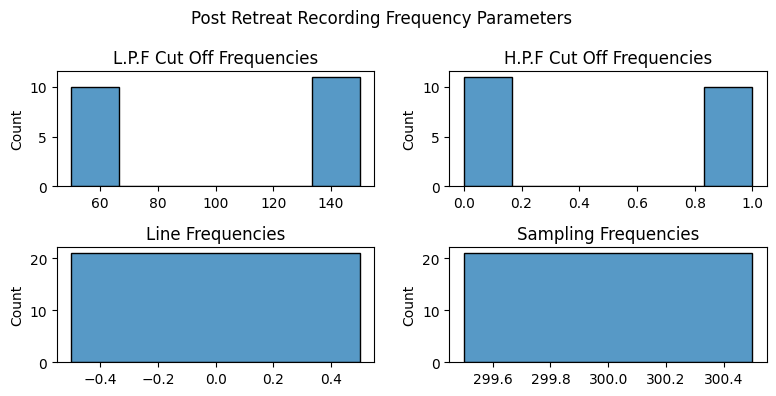

In [20]:
fig_, ax_ = plt.subplots(2, 2, figsize=(8,4))

sns.histplot(post_lowcuts, ax=ax_[0,0])
ax_[0,0].set_title("L.P.F Cut Off Frequencies")

sns.histplot(post_highcuts, ax=ax_[0,1])
ax_[0,1].set_title("H.P.F Cut Off Frequencies")

sns.histplot(post_linefreq, ax=ax_[1,0])
ax_[1,0].set_title("Line Frequencies")

sns.histplot(post_sfreq, ax=ax_[1,1])
ax_[1,1].set_title("Sampling Frequencies")

fig_.suptitle("Post Retreat Recording Frequency Parameters")
fig_.tight_layout()

In [21]:
fmin_, fmax_ = 1, 150

<ipython-input-22-b4d017b520df>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


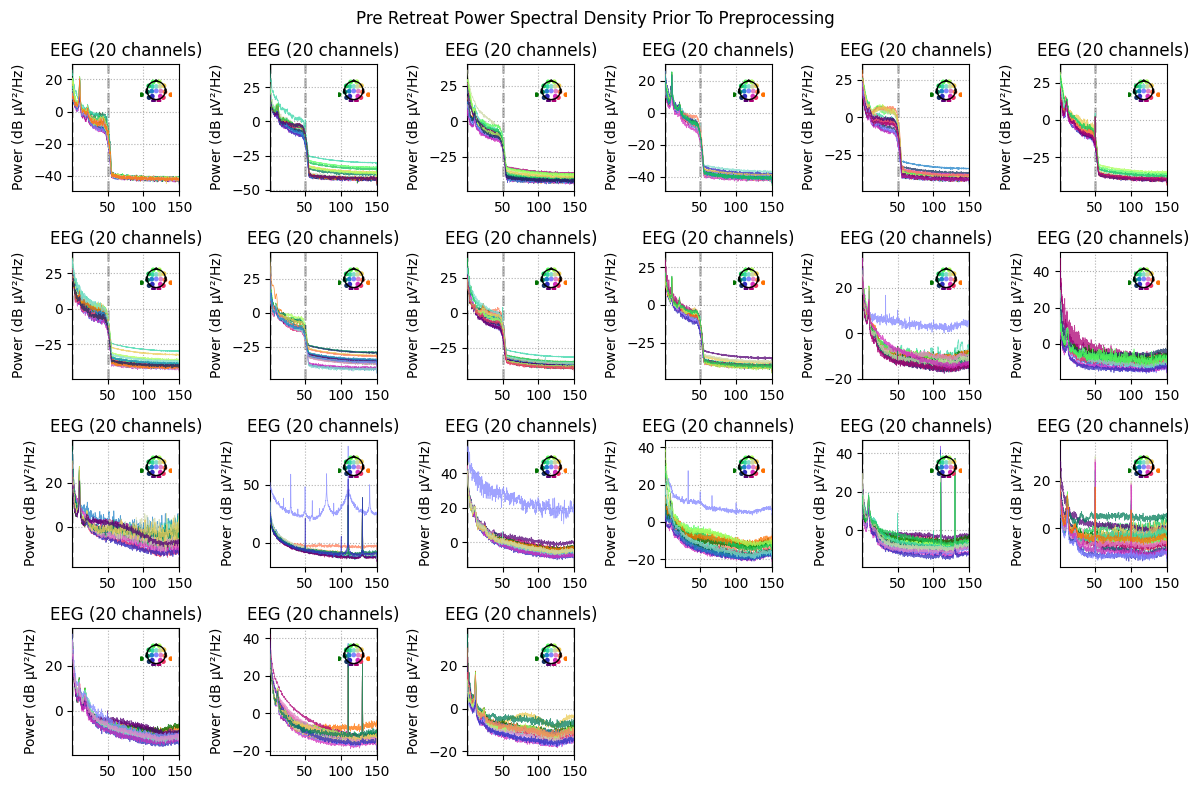

In [22]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(pre_raw):
        pre_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(pre_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Pre Retreat Power Spectral Density Prior To Preprocessing")
fig_.tight_layout()

<ipython-input-23-07791613eed4>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


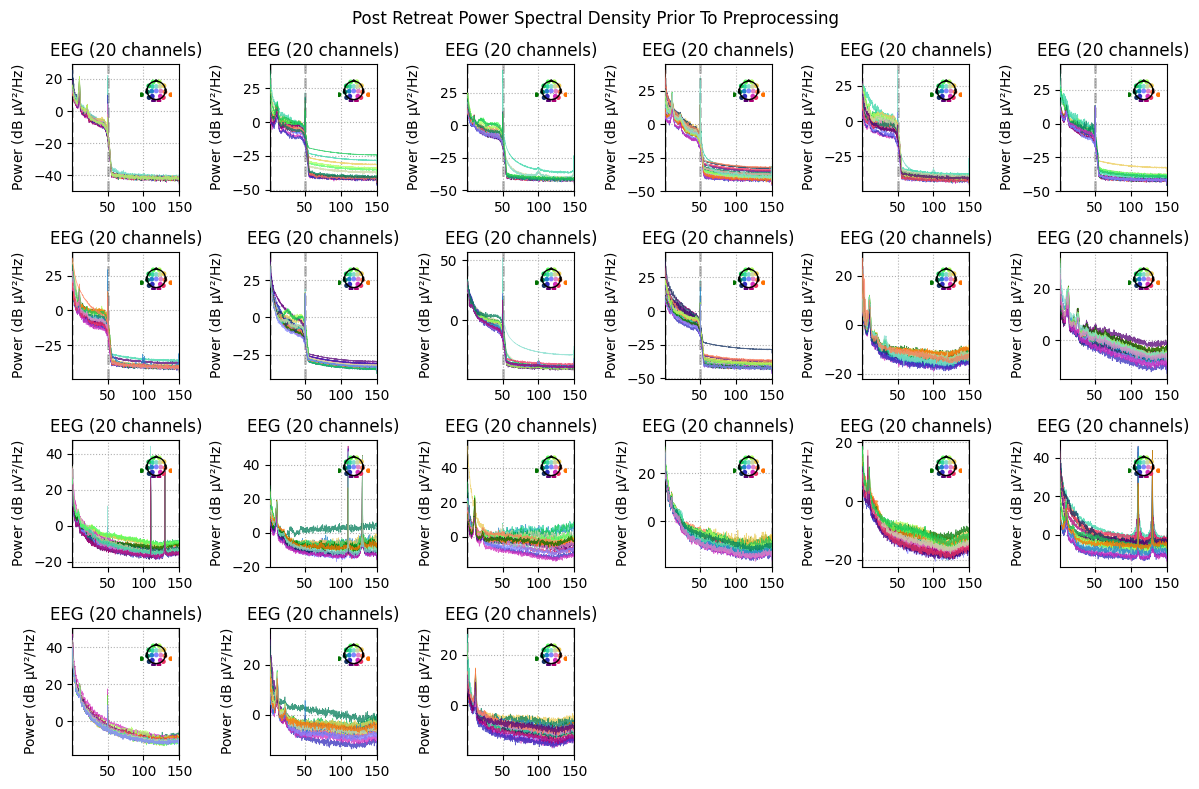

In [23]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(post_raw):
        post_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(post_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Post Retreat Power Spectral Density Prior To Preprocessing")
fig_.tight_layout()

In [24]:
lcut, hcut = 1, 35

pre_raw = [raw.filter(l_freq=lcut, h_freq=hcut) for raw in pre_raw]
post_raw = [raw.filter(l_freq=lcut, h_freq=hcut) for raw in post_raw]

<ipython-input-25-f5cc8b2f1d56>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


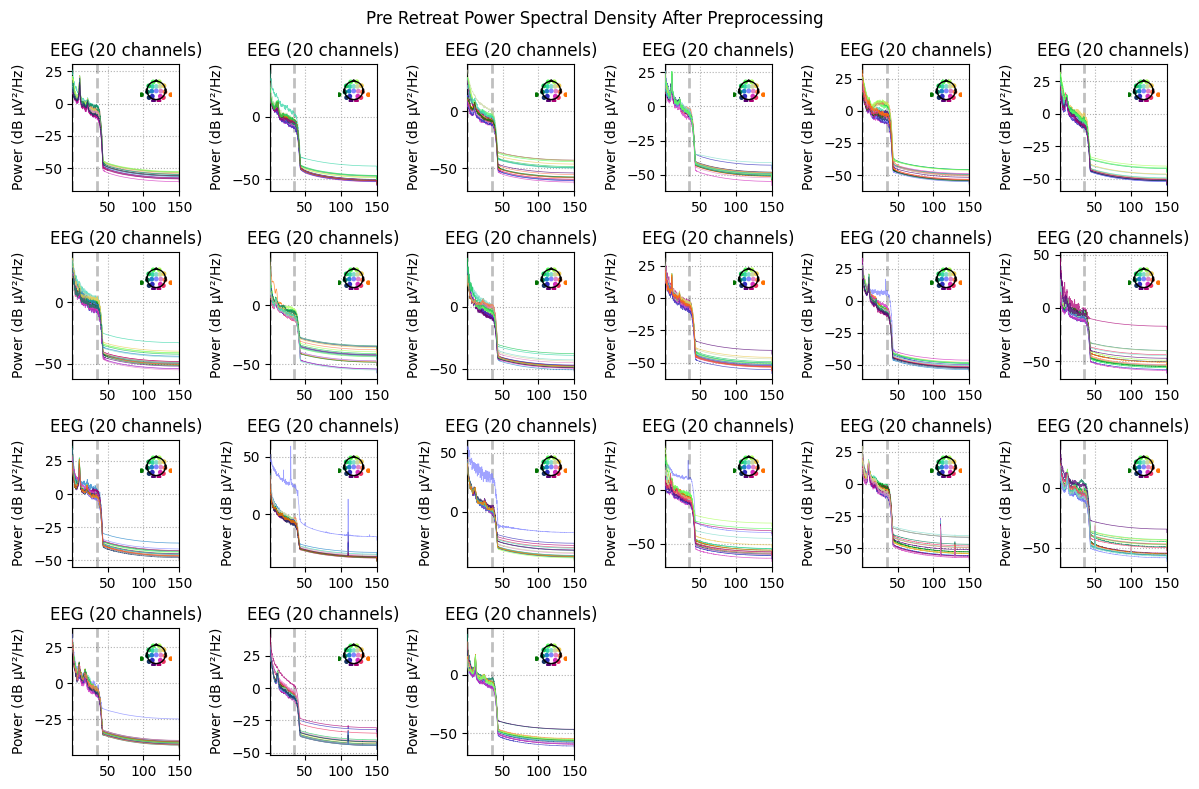

In [25]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(pre_raw):
        pre_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(pre_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Pre Retreat Power Spectral Density After Preprocessing")
fig_.tight_layout()

<ipython-input-26-5387d28ce807>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_.tight_layout()


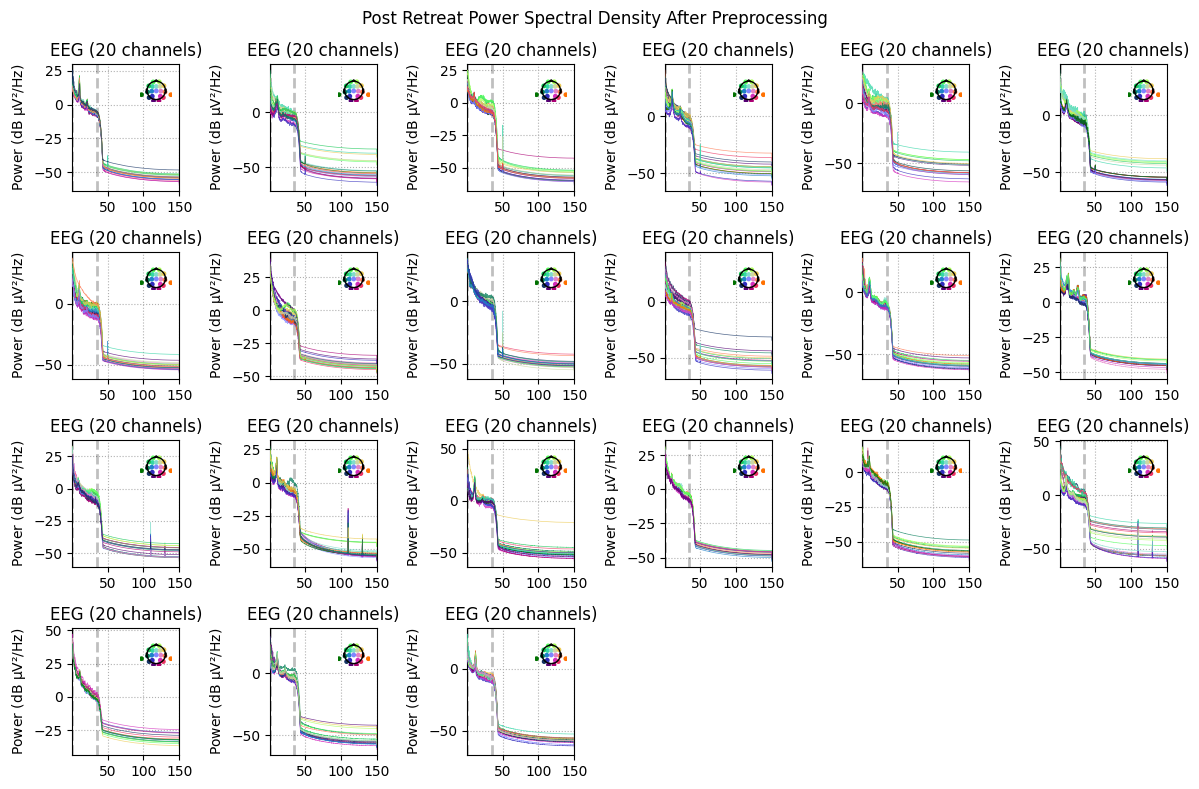

In [26]:
fig_, ax_ = plt.subplots(4, 6, figsize=(12,8))

for r in range(ax_.flatten().shape[0]):
    if r<len(post_raw):
        post_raw[r].plot_psd(fmin=fmin_, fmax=fmax_, ax=ax_.flatten()[r])
    elif r>=len(post_raw):
        ax_.flatten()[r].set_visible(False)

fig_.suptitle("Post Retreat Power Spectral Density After Preprocessing")
fig_.tight_layout()

## Features Computation & Analysis

In [27]:
channels = pre_raw[0].ch_names
channels = map(electrode_name, channels)
channels = list(channels)

len(channels)

20

In [28]:
delta = [1, 4]
theta = [4, 8]
alpha = [8, 12]
beta = [12, 30]

fs = pre_raw[0].info['sfreq']

### Bands Power

In [29]:
preretreat = np.array([raw.get_data() for raw in pre_raw])
postretreat = np.array([raw.get_data() for raw in post_raw])
preretreat.shape, postretreat.shape

((21, 20, 126001), (21, 20, 126001))

In [30]:
pre_retreat_psds = []
post_retreat_psds = []

for s, s_eeg in enumerate(preretreat):
    freqs, spectrum = spectral.compute_spectrum_welch(s_eeg,fs)
    pre_retreat_psds.append(spectrum)
for s, s_eeg in enumerate(postretreat):
    freqs, spectrum = spectral.compute_spectrum_welch(s_eeg,fs)
    post_retreat_psds.append(spectrum)

pre_retreat_psds = np.array(pre_retreat_psds)
post_retreat_psds = np.array(post_retreat_psds)

pre_retreat_psds = (pre_retreat_psds - pre_retreat_psds.min()) / (pre_retreat_psds.max() - pre_retreat_psds.min())
post_retreat_psds = (post_retreat_psds - post_retreat_psds.min()) / (post_retreat_psds.max() - post_retreat_psds.min())

psd_freqs = freqs
pre_retreat_psds.shape, post_retreat_psds.shape

((21, 20, 151), (21, 20, 151))

In [31]:
# pre-retreat Bands Power

delta_index = np.argwhere((psd_freqs>=delta[0]) & (psd_freqs<=delta[1]))
theta_index = np.argwhere((psd_freqs>=theta[0]) & (psd_freqs<=theta[1]))
alpha_index = np.argwhere((psd_freqs>=alpha[0]) & (psd_freqs<=alpha[1]))
beta_index = np.argwhere((psd_freqs>=beta[0]) & (psd_freqs<=beta[1]))

delta_band_power = np.mean(pre_retreat_psds[:,:,delta_index].squeeze(), axis=-1)
theta_band_power = np.mean(pre_retreat_psds[:,:,theta_index].squeeze(), axis=-1)
alpha_band_power = np.mean(pre_retreat_psds[:,:,alpha_index].squeeze(), axis=-1)
beta_band_power = np.mean(pre_retreat_psds[:,:,beta_index].squeeze(), axis=-1)

delta_band_power = pd.DataFrame(delta_band_power, columns=[ch + "-δ" for ch in channels])
theta_band_power = pd.DataFrame(theta_band_power, columns=[ch + "-θ" for ch in channels])
alpha_band_power = pd.DataFrame(alpha_band_power, columns=[ch + "-ɑ" for ch in channels])
beta_band_power = pd.DataFrame(beta_band_power, columns=[ch + "-β" for ch in channels])

pre_retreat_bands_power = pd.concat([delta_band_power, theta_band_power, alpha_band_power, beta_band_power], axis=1)

In [32]:
# post-retreat Bands Power

delta_index = np.argwhere((psd_freqs>=delta[0]) & (psd_freqs<=delta[1]))
theta_index = np.argwhere((psd_freqs>=theta[0]) & (psd_freqs<=theta[1]))
alpha_index = np.argwhere((psd_freqs>=alpha[0]) & (psd_freqs<=alpha[1]))
beta_index = np.argwhere((psd_freqs>=beta[0]) & (psd_freqs<=beta[1]))

delta_band_power = np.mean(post_retreat_psds[:,:,delta_index].squeeze(), axis=-1)
theta_band_power = np.mean(post_retreat_psds[:,:,theta_index].squeeze(), axis=-1)
alpha_band_power = np.mean(post_retreat_psds[:,:,alpha_index].squeeze(), axis=-1)
beta_band_power = np.mean(post_retreat_psds[:,:,beta_index].squeeze(), axis=-1)

delta_band_power = pd.DataFrame(delta_band_power, columns=[ch + "-δ" for ch in channels])
theta_band_power = pd.DataFrame(theta_band_power, columns=[ch + "-θ" for ch in channels])
alpha_band_power = pd.DataFrame(alpha_band_power, columns=[ch + "-ɑ" for ch in channels])
beta_band_power = pd.DataFrame(beta_band_power, columns=[ch + "-β" for ch in channels])

post_retreat_bands_power = pd.concat([delta_band_power, theta_band_power, alpha_band_power, beta_band_power], axis=1)

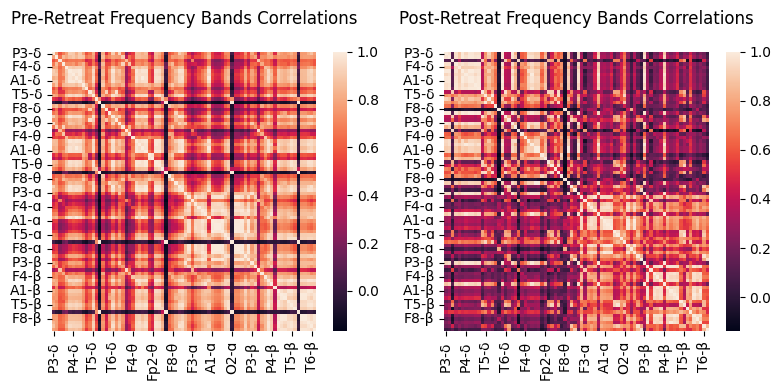

In [33]:
fig_, ax_ = plt.subplots(1, 2, figsize=(8,4))

sns.heatmap(pre_retreat_bands_power.corr(), ax=ax_[0])
ax_[0].set_title("Pre-Retreat Frequency Bands Correlations", pad=20)

sns.heatmap(post_retreat_bands_power.corr(), ax=ax_[1])
ax_[1].set_title("Post-Retreat Frequency Bands Correlations", pad=20)

fig_.tight_layout()

In [34]:
X = pre_retreat_bands_power
Y = post_retreat_bands_power

X -= X.mean(axis=0)
Y -= Y.mean(axis=0)

In [35]:
bands_power_CCA = CCA(n_components=20, scale=True)
bands_power_CCA.fit(X,Y)

CCA(n_components=20)

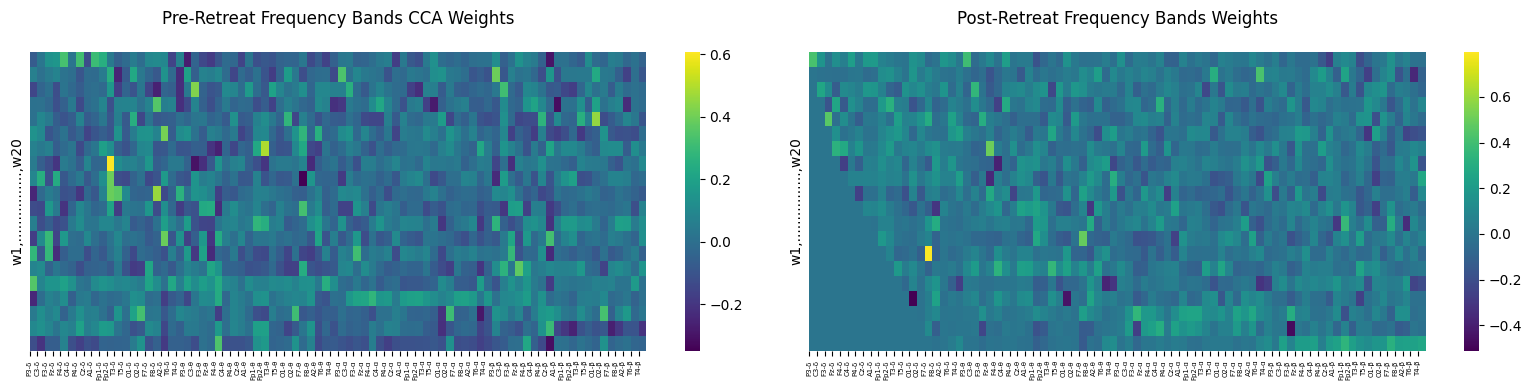

In [62]:
fig_, ax_ = plt.subplots(1, 2, figsize=(16,4))

sns.heatmap(bands_power_CCA.x_weights_.T, ax=ax_[0], cmap="viridis")
ax_[0].set_title("Pre-Retreat Frequency Bands CCA Weights", pad=20)
ax_[0].set_xticks(np.arange(X.shape[1]))
ax_[0].set_xticklabels(X.columns)
ax_[0].tick_params(axis='x', labelsize=5)
ax_[0].set_yticks([])
ax_[0].set_yticklabels([])
ax_[0].set_ylabel("w1,................,w20")

sns.heatmap(bands_power_CCA.y_weights_.T, ax=ax_[1], cmap="viridis")
ax_[1].set_title("Post-Retreat Frequency Bands Weights", pad=20)
ax_[1].set_xticks(np.arange(Y.shape[1]))
ax_[1].set_xticklabels(Y.columns)
ax_[1].tick_params(axis='x', labelsize=5)
ax_[1].set_yticks([])
ax_[1].set_yticklabels([])
ax_[1].set_ylabel("w1,................,w20")

fig_.tight_layout()